## Model training

In [ ]:
# Cell 1: Setup & Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc # Garbage collection
from pathlib import Path

# Scikit-Learn Imports for the Econometric Model
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- CONFIGURATION ---
BASE_DIR = Path.home() / "work" # Adjust if your path is different
FEATURES_PATH = BASE_DIR / "features_sampled_e10_2023_2024.parquet"

# Define cut dates for Time Series Split
TRAIN_END = pd.Timestamp("2024-06-30")
VALID_END = pd.Timestamp("2024-09-30")

print("Setup complete. Econometric libraries loaded.")

Setup complete. Econometric libraries loaded.


In [ ]:
# Cell 2: Data Loading & Optimization

# --- 1. Load Data ---
df = pd.read_parquet(FEATURES_PATH)

# Keep time_cell temporarily for sorting
keep_cols = [
    "station_uuid", "date", "time_cell", "price", 
    "price_lag_1d", "price_lag_2d", "price_lag_3d", "price_lag_7d"
]

df = df[keep_cols]

# --- 2. Memory Optimization ---
df["date"] = pd.to_datetime(df["date"])
# Optimize floats
float_cols = [c for c in df.columns if "price" in c or "time_cell" in c]
for c in float_cols:
    df[c] = df[c].astype("float32")

# --- 3. Sort by time (Deterministic) ---
# Sort by date AND time_cell to ensure 00:00 comes before 00:30
df = df.sort_values(["station_uuid", "date", "time_cell"]).reset_index(drop=True)

# NOW we can drop time_cell as it's not a feature for the pure AR model
df = df.drop(columns=["time_cell"])

print(f"Data Loaded and Sorted. Shape: {df.shape}")

Data Loaded. Shape: (14737608, 7)
station_uuid            object
date            datetime64[ns]
price                  float32
price_lag_1d           float32
price_lag_2d           float32
price_lag_3d           float32
price_lag_7d           float32
dtype: object


In [3]:
# Cell 3: Feature Definition & Splitting

# --- Feature Groups ---
TARGET = "price"

FEATURES = [
    "price_lag_1d", 
    "price_lag_2d", 
    "price_lag_3d",
    "price_lag_7d"
]

# --- Time Series Split ---
train_mask = df["date"] <= TRAIN_END
valid_mask = (df["date"] > TRAIN_END) & (df["date"] <= VALID_END)
test_mask  = df["date"] > VALID_END

print(f"Features used: {len(FEATURES)}")
print(f"Train rows: {train_mask.sum():,}")
print(f"Test rows : {test_mask.sum():,}")

# Create datasets
X_train = df.loc[train_mask, FEATURES]
y_train = df.loc[train_mask, TARGET]

X_valid = df.loc[valid_mask, FEATURES]
y_valid = df.loc[valid_mask, TARGET]

X_test  = df.loc[test_mask, FEATURES]
y_test  = df.loc[test_mask, TARGET]

# Clean up
del df
gc.collect()

Features used: 4
Train rows: 10,913,967
Test rows : 1,899,013


0

In [4]:
# Cell 4: Establishing Baselines

def get_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

print("--- BASELINES (TEST SET) ---")

# 1. Naive Baseline (Yesterday same time)
b1_mae, b1_rmse = get_metrics(y_test, X_test["price_lag_1d"])
print(f"Yesterday (Lag1):  MAE={b1_mae:.4f} | RMSE={b1_rmse:.4f}")

# 2. Weekly Baseline (Last week same time)
b2_mae, b2_rmse = get_metrics(y_test, X_test["price_lag_7d"])
print(f"Last Week (Lag7):  MAE={b2_mae:.4f} | RMSE={b2_rmse:.4f}")

# 3. Smoothing Baseline (Avg of last 3 days)
avg_3d = (X_test["price_lag_1d"] + X_test["price_lag_2d"] + X_test["price_lag_3d"]) / 3
b3_mae, b3_rmse = get_metrics(y_test, avg_3d)
print(f"Avg 3 Days:        MAE={b3_mae:.4f} | RMSE={b3_rmse:.4f}")

--- BASELINES (TEST SET) ---
Yesterday (Lag1):  MAE=0.0140 | RMSE=0.0239
Last Week (Lag7):  MAE=0.0210 | RMSE=0.0300
Avg 3 Days:        MAE=0.0142 | RMSE=0.0218


In [5]:
# Cell 5: Panel Autoregressive Distributed Lag (ARDL) Model - MINIMAL

print("Training Advanced Econometric Model (Panel ARDL / Ridge)...")

# 1. Define the Econometric Pipeline
# Only history lags remaining
numeric_features = [
    "price_lag_1d", "price_lag_2d", "price_lag_3d",
    "price_lag_7d"
]

# Simple pipeline: Standardize -> Regress
econometric_model = Pipeline([
    ("scaler", StandardScaler()), 
    ("regressor", Ridge(alpha=1.0))
])

# 2. Train on the Training Set
econometric_model.fit(X_train, y_train)

# 3. Evaluate on Test Set
y_pred_linear = econometric_model.predict(X_test)
lin_mae, lin_rmse = get_metrics(y_test, y_pred_linear)

print("\n" + "="*40)
print(f"ECONOMETRIC MODEL RESULTS")
print(f"MAE:  {lin_mae:.4f}")
print(f"RMSE: {lin_rmse:.4f}")
print(f"Improvement vs Lag1 Baseline: {((b1_mae - lin_mae) / b1_mae) * 100:.2f}%")
print("="*40)

# 4. Interpret Coefficients
coeffs = econometric_model.named_steps["regressor"].coef_

print("\nModel Coefficients (Drivers):")
# Sort by absolute impact
for name, coef in sorted(zip(numeric_features, coeffs), key=lambda x: -abs(x[1])):
    print(f"{name:30s} : {coef:+.4f}")

Training Advanced Econometric Model (Panel ARDL / Ridge)...

ECONOMETRIC MODEL RESULTS
MAE:  0.0137
RMSE: 0.0208
Improvement vs Lag1 Baseline: 2.12%

Model Coefficients (Drivers):
price_lag_1d                   : +0.0493
price_lag_2d                   : +0.0183
price_lag_7d                   : +0.0142
price_lag_3d                   : +0.0118


In [6]:
# Cell 6: Export Model
import joblib

# Define the export path
model_filename = "fuel_price_model_v1.joblib"
export_path = BASE_DIR / model_filename

# Save the pipeline object
# This saves the Scaler logic AND the Ridge weights together
joblib.dump(econometric_model, export_path)

print(f"Model successfully exported to: {export_path}")
print(f"File size: {export_path.stat().st_size / 1024:.2f} KB")

Model successfully exported to: /home/jovyan/work/fuel_price_model_v1.joblib
File size: 1.51 KB


In [7]:
# Cell 7: Testing the model on two different inputs

import joblib
import pandas as pd

# 1. Load the model (only needs to be done once at startup)
model = joblib.load("fuel_price_model_v1.joblib")

# 2. Prepare Input Data
# The input MUST be a DataFrame with column names matching the training features
# Note: We removed 'time_cell', 'dow', 'brand', etc. It's just lags now.
input_data = pd.DataFrame([
    {
        # Example: Station A (Stable prices)
        "price_lag_1d": 1.759,
        "price_lag_2d": 1.749,
        "price_lag_3d": 1.755,
        "price_lag_7d": 1.720,
    },
    {
        # Example: Station B (Price spike yesterday)
        "price_lag_1d": 1.850, # High yesterday
        "price_lag_2d": 1.720,
        "price_lag_3d": 1.710,
        "price_lag_7d": 1.700,
    }
])

# 3. Predict
# The pipeline automatically scales the data and applies the weights
predictions = model.predict(input_data)

print("Predicted Prices:")
print(predictions) 
# Output might look like: [1.752, 1.810]

Predicted Prices:
[1.75217637 1.78530561]


Reloading data for backtesting...
Starting Walk-Forward Validation from 2024-01-01 to 2024-12-31...


Backtesting Months: 100%|██████████| 12/12 [00:11<00:00,  1.00it/s]



WALK-FORWARD VALIDATION RESULTS
  Month  Test_Rows    MAE   RMSE  Baseline_MAE  Improvement
2024-01     647447 0.0157 0.0232        0.0162       0.0293
2024-02     609067 0.0150 0.0220        0.0155       0.0344
2024-03     652586 0.0144 0.0206        0.0139      -0.0296
2024-04     632599 0.0141 0.0204        0.0135      -0.0443
2024-05     653232 0.0133 0.0205        0.0133      -0.0025
2024-06     631092 0.0127 0.0197        0.0130       0.0191
2024-07     650256 0.0119 0.0176        0.0122       0.0306
2024-08     647988 0.0143 0.0208        0.0141      -0.0127
2024-09     626384 0.0152 0.0222        0.0148      -0.0252
2024-10     646283 0.0148 0.0219        0.0147      -0.0049
2024-11     623221 0.0130 0.0197        0.0135       0.0353
2024-12     629509 0.0132 0.0205        0.0139       0.0499
--------------------------------------------------
Average Improvement over Baseline: 0.66%


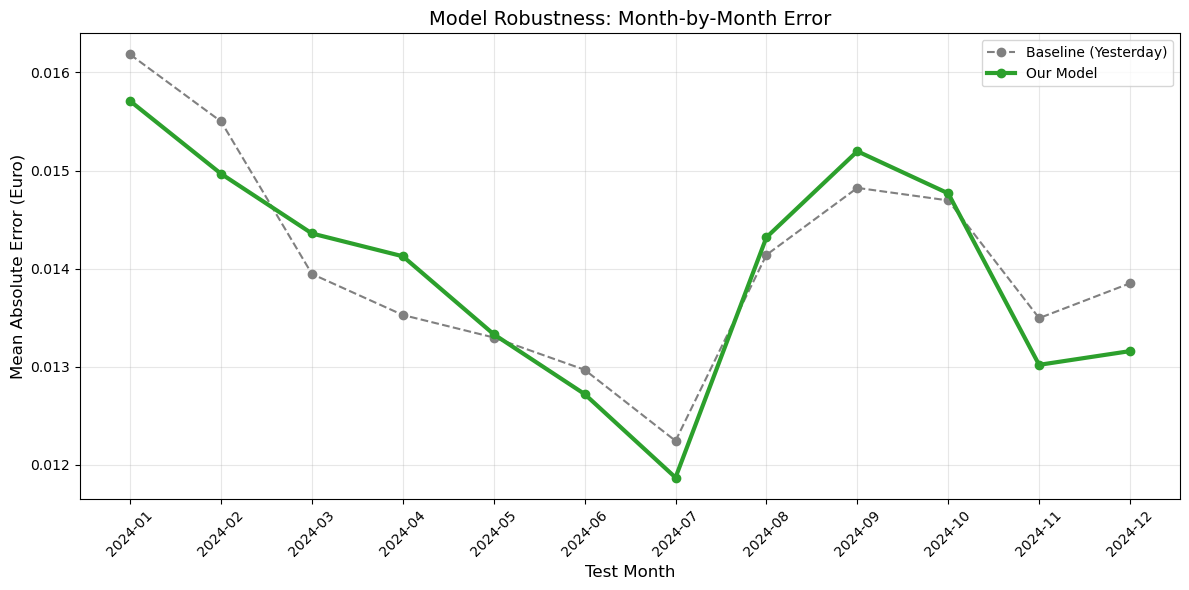

3842

In [8]:
# Cell 8: Extensive Walk-Forward Backtesting

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.base import clone
from tqdm import tqdm

# --- 1. RELOAD DATA (Because we deleted 'df' earlier) ---
print("Reloading data for backtesting...")
df = pd.read_parquet(FEATURES_PATH)
df["date"] = pd.to_datetime(df["date"])

# Apply the same type optimizations to save RAM
float_cols = [c for c in df.columns if "price" in c or "mom" in c]
for c in float_cols:
    df[c] = df[c].astype("float32")
    
# Sort strictly by time
df = df.sort_values(["date", "station_uuid"]).reset_index(drop=True)

# --- 2. CONFIGURATION ---
TARGET = "price"
# We must use the SAME features the model was trained on
# (Based on your previous screenshots, these are the 4 lags)
numeric_features = [
    "price_lag_1d", 
    "price_lag_2d", 
    "price_lag_3d",
    "price_lag_7d"
]

START_VALIDATION_DATE = pd.Timestamp("2024-01-01") 
FINAL_DATE = df["date"].max()

print(f"Starting Walk-Forward Validation from {START_VALIDATION_DATE.date()} to {FINAL_DATE.date()}...")

# Store results
monthly_metrics = []

# Generate monthly cutoffs (End of each month)
cutoffs = pd.date_range(start=START_VALIDATION_DATE, end=FINAL_DATE, freq='ME')

# --- 3. THE LOOP ---
for cutoff in tqdm(cutoffs, desc="Backtesting Months"):
    
    # Define Temporal Split
    # Test: The specific month we are currently looping over
    test_month_start = cutoff - pd.DateOffset(days=cutoff.day - 1)
    test_month_end = cutoff
    
    # Train: Everything BEFORE this test month
    train_mask = df["date"] < test_month_start
    test_mask = (df["date"] >= test_month_start) & (df["date"] <= test_month_end)
    
    # Skip if no data
    if test_mask.sum() == 0:
        continue
        
    X_train_fold = df.loc[train_mask, numeric_features]
    y_train_fold = df.loc[train_mask, TARGET]
    
    X_test_fold = df.loc[test_mask, numeric_features]
    y_test_fold = df.loc[test_mask, TARGET]
    
    # Re-Train Model (Fresh clone)
    # We clone the 'econometric_model' you created in Cell 5
    model_instance = clone(econometric_model)
    model_instance.fit(X_train_fold, y_train_fold)
    
    # Predict
    preds = model_instance.predict(X_test_fold)
    
    # Calculate Metrics
    mae, rmse = get_metrics(y_test_fold, preds)
    
    # Baseline Comparison (Lag 1d)
    baseline_preds = X_test_fold["price_lag_1d"]
    base_mae, _ = get_metrics(y_test_fold, baseline_preds)
    
    improvement = (base_mae - mae) / base_mae
    
    monthly_metrics.append({
        "Month": test_month_start.strftime("%Y-%m"),
        "Test_Rows": len(y_test_fold),
        "MAE": mae,
        "RMSE": rmse,
        "Baseline_MAE": base_mae,
        "Improvement": improvement
    })

# --- 4. REPORTING ---
results_df = pd.DataFrame(monthly_metrics)

print("\n" + "="*50)
print("WALK-FORWARD VALIDATION RESULTS")
print("="*50)
print(results_df.round(4).to_string(index=False))

print("-" * 50)
avg_imp = results_df["Improvement"].mean() * 100
print(f"Average Improvement over Baseline: {avg_imp:.2f}%")

# --- 5. VISUALIZATION ---
plt.figure(figsize=(12, 6))

plt.plot(results_df["Month"], results_df["Baseline_MAE"], label="Baseline (Yesterday)", linestyle="--", color="gray", marker="o")
plt.plot(results_df["Month"], results_df["MAE"], label="Our Model", color="#2ca02c", linewidth=3, marker="o")

plt.title("Model Robustness: Month-by-Month Error", fontsize=14)
plt.ylabel("Mean Absolute Error (Euro)", fontsize=12)
plt.xlabel("Test Month", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Clean up again to be safe
del df
import gc
gc.collect()